# Necessary libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, uniform

# Libraries for LightGBM
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import f1_score, average_precision_score, precision_recall_curve

# Libraries for saving and loading data from memory
import json
from joblib import dump, load
import os


# Detection of Fraudulent Transactions
The synthetic data used in the current project was provided by "BankSim: A bank payments simulator for fraud detection research (Edgar Alonso Lopez-Rojas and Stefan Axelsson). 

In [4]:
url_df = 'https://raw.githubusercontent.com/athemaris/FraudDetection_banksim/refs/heads/main/BankSim%20Dataset.csv'

banksim_df = pd.read_csv(url_df)

In [5]:
banksim_df.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,C583110837,3,M,28007,M480139044,28007,es_health,"4,426",1
1,0,C1332295774,3,M,28007,M480139044,28007,es_health,"3,245",1
2,0,C1160421902,3,M,28007,M857378720,28007,es_hotelservices,"17,632",1
3,0,C966214713,3,M,28007,M857378720,28007,es_hotelservices,"33,741",1
4,0,C1450140987,4,F,28007,M1198415165,28007,es_wellnessandbeauty,"22,011",1


In [6]:
# quick look at unique values of categorical variables

print(f'Values age: {banksim_df['age'].unique()}')
print(f'Values gender: {banksim_df['gender'].unique()}')
print(banksim_df['zipcodeOri'].unique())
print(banksim_df['zipMerchant'].unique())
print(banksim_df['category'].unique())
print(banksim_df['merchant'].unique())

Values age: ['3' '4' '2' '5' '1' '6' '0' 'U']
Values gender: ['M' 'F' 'E' 'U']
[28007]
[28007]
['es_health' 'es_hotelservices' 'es_wellnessandbeauty' 'es_sportsandtoys'
 'es_home' 'es_otherservices' 'es_fashion' 'es_leisure' 'es_travel'
 'es_barsandrestaurants' 'es_tech' 'es_hyper' 'es_transportation'
 'es_food' 'es_contents']
['M480139044' 'M857378720' 'M1198415165' 'M980657600' 'M1741626453'
 'M1535107174' 'M2122776122' 'M209847108' 'M1888755466' 'M547558035'
 'M3697346' 'M1649169323' 'M923029380' 'M495352832' 'M17379832'
 'M1294758098' 'M1748431652' 'M151143676' 'M732195782' 'M840466850'
 'M855959430' 'M50039827' 'M2080407379' 'M2011752106' 'M692898500'
 'M1353266412' 'M1873032707' 'M78078399' 'M933210764' 'M348875670'
 'M348934600' 'M1823072687' 'M1053599405' 'M85975013' 'M349281107'
 'M1352454843' 'M117188757' 'M1946091778' 'M97925176' 'M1842530320'
 'M677738360' 'M1313686961' 'M1600850729' 'M1872033263' 'M1400236507'
 'M1913465890' 'M45060432' 'M1788569036' 'M1416436880' 'M172640

The values in `gender` stand for:
* E stands for ENTERPRISE.
* U stands for UNKNOWN.
* M stands for MALE
* F stands for FEMALE

The value U in `age` stands for UNKNOWN.

In [7]:
# collect info about the type of each variable

banksim_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   step         594643 non-null  int64 
 1   customer     594643 non-null  object
 2   age          594643 non-null  object
 3   gender       594643 non-null  object
 4   zipcodeOri   594643 non-null  int64 
 5   merchant     594643 non-null  object
 6   zipMerchant  594643 non-null  int64 
 7   category     594643 non-null  object
 8   amount       594643 non-null  object
 9   fraud        594643 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 45.4+ MB


The Dtype of the following variables are incorrect:
- `amount` is an obejct and needs to be converted into a float

In [8]:
# let's convert amount type from object to float

banksim_df['amount'] = banksim_df['amount'].str.replace(',', '').astype(float)

print(banksim_df['amount'].dtype)

float64


## Feature Engineering

In order to set up the dataset for LightGBM, we first need to make sure that the categorical variables are of the type `category` LightGBM can use categorical features directly, but its processing actually relies on integer code. 
Pandas `dtype='category'` naturally provides these integer codes. 

This is the first step to do before the feature derivation process. 

In [9]:
# creating a working copy of the dataset
df = banksim_df.copy()

In [10]:
# changing the type of categorical variables to 'category' for LightGBM
for c in ['customer','age','gender','merchant','category']:
    if c in df.columns:
        df[c] = df[c].astype('category')



In [11]:
# check if the conversion worked properly
print(df.dtypes)

step              int64
customer       category
age            category
gender         category
zipcodeOri        int64
merchant       category
zipMerchant       int64
category       category
amount          float64
fraud             int64
dtype: object


The new dataset `df` contains all the original variables correctly converted. 

### Features Building

In order to extract some useful data from the raw dataset, the following variables will be computed:
* `log_amount`: stabilizes skewed amounts
* `cust_txn_count_prev`: how many transactions this customer had before now
* `cust_amt_mean_prev`: customer’s average amount before now
* `amt_minus_cust_mean_diff`: difference between current amount and customer's historical mean amount
* `time_since_last_cust_txn`: days since customer’s last transaction
* `time_since_last_cust_merchant`: days since customer last used this merchant
* `cust_merchant_txn_count_prev`: familiarity with merchant
* `cust_category_count_prev`: familiarity with category

Before doing so, the dataset will be sorted so every feature is computed on the same sorted timeline. 

In [ ]:
# adding a unique row identifier (_row_id) to save the original order of the dataset
df['_row_id'] = np.arange(len(df), dtype=np.int64)
print(df['_row_id'].head())

0    0
1    1
2    2
3    3
4    4
Name: _row_id, dtype: int64


After preserving the original row order, we now sort the working dataset by `['customer', 'step', 'merchant', 'category']`. 
This establishes a time-aware sequence per customer so ‘previous’ features only use past information.


In [13]:
# creating a sorted version of the dataset for a robust feature engineering
df_sort = df.sort_values(['customer', 'step', 'merchant', 'category']).copy()

# this way the dataset is sorted by customer, step, merchant and category
# it is useful because now we can group by customer and step to see all transactions made by a customer at a certain step

In [14]:
# let's add the first new variable: log_amount
# it is the logarithm of the amount + 1 (to avoid log(0))

df_sort['log_amount'] = np.log1p(df_sort['amount'])

# let's check the new variable and compare it to amount

print(df_sort[['amount', 'log_amount']].head())
print(f"\n Here's a description of amount: \n {df_sort['amount'].describe()}")
print(f"\n Here's a description of log_amount: \n {df_sort['log_amount'].describe()}")

         amount  log_amount
86563   14387.0    9.574150
111048   1669.0    7.420579
122828   5618.0    8.633909
125868   1474.0    7.296413
130310   4742.0    8.464425

 Here's a description of amount: 
 count    594643.000000
mean       3452.935302
std       10674.403405
min           0.000000
25%         951.000000
50%        2399.000000
75%        4047.000000
max      832996.000000
Name: amount, dtype: float64

 Here's a description of log_amount: 
 count    594643.000000
mean          7.465628
std           1.293303
min           0.000000
25%           6.858565
50%           7.783224
75%           8.305978
max          13.632785
Name: log_amount, dtype: float64


In [15]:
# adding cust_txn_count_prev: number of previous transactions by the customer

df_sort['cust_txn_count_prev'] = df_sort.groupby('customer', observed=True).cumcount().astype('int64')

print (df_sort[['customer', 'cust_txn_count_prev']].head())


           customer  cust_txn_count_prev
86563   C1000148617                    0
111048  C1000148617                    1
122828  C1000148617                    2
125868  C1000148617                    3
130310  C1000148617                    4


In [16]:
# adding cust_amt_mean_prev: customer's historical mean amount up to previous txn

prev_sum  = df_sort.groupby('customer', observed=True)['amount'].cumsum() - df_sort['amount'] # cumulative sum of amounts per customer, excluding current txn
prev_count = df_sort.groupby('customer', observed=True).cumcount() # number of previous transactions per customer

# calculating the mean amount of previous transactions
df_sort['cust_amt_mean_prev'] = (
    prev_sum / prev_count.replace(0, np.nan)
).fillna(0).astype('float64')  # replacing NaN with 0 for customers with no previous transactions

# checking the new variable
print(df_sort[['customer', 'amount', 'cust_amt_mean_prev']].head(10))

           customer   amount  cust_amt_mean_prev
86563   C1000148617  14387.0            0.000000
111048  C1000148617   1669.0        14387.000000
122828  C1000148617   5618.0         8028.000000
125868  C1000148617   1474.0         7224.666667
130310  C1000148617   4742.0         5787.000000
132931  C1000148617    171.0         5578.000000
135609  C1000148617   3479.0         4676.833333
137616  C1000148617   5514.0         4505.714286
141258  C1000148617   1484.0         4631.750000
143862  C1000148617   1323.0         4282.000000


In [17]:
# descriptive statistics of the new variable cust_amt_mean_prev

df_sort['cust_amt_mean_prev'].describe()

count    594643.000000
mean       3736.603881
std        4962.501778
min           0.000000
25%        2605.056809
50%        2872.770642
75%        3313.140755
max      614259.000000
Name: cust_amt_mean_prev, dtype: float64

In [18]:
# adding amt_minus_cust_mean_diff: difference between current amount and customer's historical mean amount

df_sort['amt_minus_cust_mean_diff'] = df_sort['amount'] - df_sort['cust_amt_mean_prev'].astype('float64')
print(df_sort[['amount', 'cust_amt_mean_prev', 'amt_minus_cust_mean_diff']].head())

         amount  cust_amt_mean_prev  amt_minus_cust_mean_diff
86563   14387.0            0.000000              14387.000000
111048   1669.0        14387.000000             -12718.000000
122828   5618.0         8028.000000              -2410.000000
125868   1474.0         7224.666667              -5750.666667
130310   4742.0         5787.000000              -1045.000000


In [19]:
# adding time_since_last_cust_txn: time since last transaction by the customer

df_sort['time_since_last_cust_txn'] = (
    df_sort['step'] - df_sort.groupby('customer', observed=True)['step'].shift(1)
).fillna(0).astype('float64') #fillna(0) for customers with no previous transactions

print(df_sort[['customer', 'step', 'time_since_last_cust_txn']].head(10))

           customer  step  time_since_last_cust_txn
86563   C1000148617    30                       0.0
111048  C1000148617    38                       8.0
122828  C1000148617    42                       4.0
125868  C1000148617    43                       1.0
130310  C1000148617    44                       1.0
132931  C1000148617    45                       1.0
135609  C1000148617    46                       1.0
137616  C1000148617    47                       1.0
141258  C1000148617    48                       1.0
143862  C1000148617    49                       1.0


In [20]:
# adding time_since_last_cust_merchant: time since last transaction by the customer at this merchant

df_sort['time_since_last_cust_merchant'] = (
    df_sort['step'] - df_sort.groupby(['customer', 'merchant'], observed=True)['step'].shift(1)
).fillna(0).astype('float64') #fillna(0) for customers with no previous transactions at this merchant

print(df_sort[['customer', 'merchant', 'step', 'time_since_last_cust_merchant']].head(10))

           customer     merchant  step  time_since_last_cust_merchant
86563   C1000148617  M1888755466    30                            0.0
111048  C1000148617  M1741626453    38                            0.0
122828  C1000148617  M1888755466    42                           12.0
125868  C1000148617   M840466850    43                            0.0
130310  C1000148617  M1823072687    44                            0.0
132931  C1000148617  M1823072687    45                            1.0
135609  C1000148617  M1823072687    46                            1.0
137616  C1000148617  M1823072687    47                            1.0
141258  C1000148617    M85975013    48                            0.0
143862  C1000148617  M1823072687    49                            2.0


In [21]:
# adding cust_merchant_txn_count_prev: number of previous transactions by the customer at this merchant

df_sort['cust_merchant_txn_count_prev'] = df_sort.groupby(['customer', 'merchant'], observed=True).cumcount().astype('int64')

print(df_sort[['customer', 'merchant', 'cust_merchant_txn_count_prev']].head())

           customer     merchant  cust_merchant_txn_count_prev
86563   C1000148617  M1888755466                             0
111048  C1000148617  M1741626453                             0
122828  C1000148617  M1888755466                             1
125868  C1000148617   M840466850                             0
130310  C1000148617  M1823072687                             0


In [22]:
# adding cust_category_count_prev: number of previous transactions by the customer in this category

df_sort['cust_category_count_prev'] = df_sort.groupby(['customer', 'category'], observed=True).cumcount().astype('int64')

print(df_sort[['customer', 'category', 'cust_category_count_prev']].head(10))


           customer           category  cust_category_count_prev
86563   C1000148617   es_otherservices                         0
111048  C1000148617   es_sportsandtoys                         0
122828  C1000148617   es_otherservices                         1
125868  C1000148617            es_tech                         0
130310  C1000148617  es_transportation                         0
132931  C1000148617  es_transportation                         1
135609  C1000148617  es_transportation                         2
137616  C1000148617  es_transportation                         3
141258  C1000148617            es_food                         0
143862  C1000148617  es_transportation                         4


### Resulting dataset after building the new features

Now we have all the new variables in the dataset `df_sort`, which is still sorted. 
The next step consists of bringing back the original order of the data, like in `df`, through `_row_id`. 

In [23]:
# restoring the original order of the dataset using _row_id
df_final = df_sort.sort_values('_row_id').copy()

# LightGBM

## Features and Target selection
Since `zipcodeOri` and `zipMerchant` both contain only one unique value (28007), they offer no predictive value, so they will be dropped by the X features along with `_row_id` which was only added to preserve the original order of the data. 

In [24]:
feature_cols = [
    # raw
    'step','age','gender','category','amount',
    'customer','merchant',
    # engineered
    'log_amount','cust_txn_count_prev','cust_amt_mean_prev',
    'amt_minus_cust_mean_diff','time_since_last_cust_txn',
    'time_since_last_cust_merchant','cust_merchant_txn_count_prev',
    'cust_category_count_prev'
]
target_col = 'fraud'

# creating a new dataset only with the columns that we need
dfm = df_final[feature_cols + [target_col]].copy()

X = dfm[feature_cols]
y = dfm[target_col].astype('int8')

## Data split
A stratified split is performed in order to keep the fraud ratio similar both in the training and testing set, since the data is heavily imbalanced. Thanks to `stratify=y`, we are able to maintain the same proportion of fraud and non-fraud cases in both sets. 

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
    ) 

As already addressed before, since the data is imbalanced, it is important to compute the `scale_pos_weight` parameter because, by default, most machine learning models are optimized for _overall accuracy_. 

In an imbalanced dataset, however, this leads to the model becoming biased toward the majority class (non-fraudulent transactions) and performing poorly on the minority class (fraudulent transactions), even though the minority class often represents the most critical cases. 

Without this parameter, misclassification errors for both classes are treated equally. 

The `scale_pos_weight` parameter addresses this issue through cost-sensitive learning: 
* It works by assigning a higher weight (penalty) to the errors made when _misclassifying_ the minority (positive) class
* By setting it to a value greater than 1 (typically the ratio of negative samples to positive samples), you force the model's objective function to give greater importance to correctly classifying the minority class

This is how usually the parameter is computed: 
$$
\text{scale pos weight} = \frac{\text{sum of negative instances}}{\text{sum of positive instances}}
$$

In [26]:
neg = int((y_train == 0).sum())
pos = int((y_train == 1).sum())
scale_pos_weight = neg / max(pos, 1)
scale_pos_weight

81.5892361111111

## Baseline LightGBM model
Here is a reasonable setup before tuning the parameters. 

### Recommended metrics to evaluate the model performance

#### PR-AUC (Precision-Recall - Area Under the Curve)

The PR curve plots Precision against Recall at various classification thresholds.
* _Precision measures_: "Of all the transactions the model flagged as fraud, how many were actually fraud?" (Minimizing false positives).
* _Recall measures_: "Of all the actual fraud cases that happened, how many did the model catch?" (Minimizing false negatives).

PR-AUC summarizes the average precision across all levels of recall. A high PR-AUC means the model is good at catching most fraud cases while keeping the rate of false alarms (False Positives) low.

#### F1-Score
The F1-score is the harmonic mean of Precision and Recall. The F1-score gives equal weight to precision and recall, rewarding models that perform reasonably well on both. 

A model that achieves perfect precision but zero recall (or vice-versa) will have an F1-score of 0 (worst score).

This is how it is computed: 
$$
\text{F1-score} = 2 \times \frac{Precision \times Recall}{Precision + Recall}
$$


In [ ]:
baseline = LGBMClassifier(
    objective='binary',
    n_estimators=600,          
    learning_rate=0.05,
    num_leaves=128,
    max_depth=-1,
    min_child_samples=200,     
    subsample=0.8,             
    subsample_freq=1,
    colsample_bytree=0.8,      
    reg_alpha=1.0,
    reg_lambda=2.0,
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

baseline.fit(
    X_train, y_train,
    categorical_feature=['customer','merchant','category','age','gender'] 
)

proba_base = baseline.predict_proba(X_test)[:, 1]
print("Baseline ROC-AUC:", roc_auc_score(y_test, proba_base))
print("Baseline PR-AUC :", average_precision_score(y_test, proba_base))

y_pred_labels = baseline.predict(X_test)              # 0/1 labels
print("Baseline F1 (0.5 threshold):", f1_score(y_test, y_pred_labels))



## Randomized Hyperparameter search

In [ ]:


param_distributions = {
    "learning_rate": uniform(0.01, 0.19),        # 0.01 to 0.20
    "num_leaves": randint(64, 513),              # 64..512
    "max_depth": [-1, 6, 8, 10, 12],
    "min_child_samples": randint(50, 2001),      # 50..2000
    "subsample": uniform(0.6, 0.4),              # 0.6..1.0
    "subsample_freq": [1, 2, 3],
    "colsample_bytree": uniform(0.6, 0.4),       # 0.6..1.0
    "reg_alpha": uniform(0.0, 10.0),
    "reg_lambda": uniform(0.0, 10.0),
    "min_split_gain": uniform(0.0, 5.0),
    "max_bin": [255, 511]
}

base_for_search = LGBMClassifier(
    objective='binary',
    n_estimators=800,         
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    random_state=42
)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=base_for_search,
    param_distributions=param_distributions,
    n_iter=20,
    scoring='average_precision',   # PR-AUC
    cv=cv,
    refit=True,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# pass categorical features once; sklearn will reuse for each fold
search.fit(X_train, y_train, categorical_feature=['customer','merchant','category','age','gender'])

print("Best PR-AUC (CV):", search.best_score_)
print("Best params:", search.best_params_)
best_params = search.best_params_


Here's the result of the `RandomizedSearchCV` saved in variables. Run this code when restarting the kernel so there's no need to restart the search everytime. 

While the best PR-AUC obtained during the search was => Best PR-AUC (CV): 0.9305187679201201

In [37]:
best_params = {'colsample_bytree': 0.7615344684232164, 'learning_rate': 0.022329526950706495, 'max_bin': 511, 
               'max_depth': 10, 'min_child_samples': 1341, 'min_split_gain': 1.2589114791268208, 'num_leaves': 449, 
               'reg_alpha': 7.12270589924442, 'reg_lambda': 1.480869299533999, 'subsample': 0.9990961940195767, 'subsample_freq': 3}

## Creating a new split with a smaller Validation set
After doing the Hyperparameter search we have identified the best main parameters. However, we still need to select to best `n_estimators` to use in the model. Another model will then be trained with a large number of estimators and a smaller validation split (15% of the data instead of 20%) and an early stopping. 

In [ ]:
# smaller validation set
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.15, stratify=y_train, random_state=42
)

final_model_es = LGBMClassifier(
    objective='binary',
    n_estimators=5000,            # large cap because ES will stop earlier
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    random_state=42,
    **best_params                 # plug the best params obtained from the search
)

final_model_es.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    eval_metric=['average_precision', 'auc'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=300, 
                           verbose=False)
    ],
    categorical_feature=['customer','merchant','category','age','gender'],
)

print("Best iteration (ES):", final_model_es.best_iteration_)
proba_val = final_model_es.predict_proba(X_val)[:, 1]
print("Val ROC-AUC:", roc_auc_score(y_val, proba_val))
print("Val PR-AUC :", average_precision_score(y_val, proba_val))


From the previous cell we were able to obtain the best tree count. So now we can train the final_model on all `X_train`. 

In [ ]:
# let's get the best tree count
best_iters = final_model_es.best_iteration_ # it returns the optimal number of trees

final_model = LGBMClassifier(
    objective='binary',
    n_estimators=best_iters,      # lock to the optimal tree count
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    random_state=42,
    **best_params
)

final_model.fit(
    X_train, y_train,
    categorical_feature=['customer','merchant','category','age','gender'],
)


## Testing the model
Now that the model is defined, it can finally be tested on the testing set. 

In [29]:
proba_test = final_model.predict_proba(X_test)[:, 1]
print("Test ROC-AUC:", roc_auc_score(y_test, proba_test))
print("Test PR-AUC :", average_precision_score(y_test, proba_test))

Test ROC-AUC: 0.9986854088467857
Test PR-AUC : 0.9306379092505168


# Saving the Trained Model
The following cell is just meant to save some important info (e.g. the best parameters, the best estimator) so we don't need to train the model everytime the kernel/session is restarted. 

In [ ]:
# 1) Save best params + CV table
with open("lgbm_best_params.json", "w") as f:
    json.dump(best_params, f, indent=2)

cv_df = pd.DataFrame(search.cv_results_)
cv_df.to_csv("lgbm_random_search_results.csv", index=False)

# 2) Save the best estimator from the search (fitted on full X_train internally)
dump(search.best_estimator_, "lgbm_best_estimator.joblib")

# 3) Save the fully refit model (trained on all X_train with best n_estimators)
dump(final_model, "lgbm_final_refit.joblib")

proba_test = final_model.predict_proba(X_test)[:, 1]

['lgbm_final_refit.joblib']

The following cell retrieves all the data saved.

In [27]:
# --- 1. Load the Final Trained Model ---
model_file = "lgbm_final_refit.joblib"
final_model = load(model_file)
print(f"Model object: {final_model}")

# --- 2. Load the Best Parameters ---
params_file = "lgbm_best_params.json"
with open(params_file, "r") as f:
    best_params = json.load(f)

# --- 3. Load the Best Estimator from the Search ---
# This is the 'search.best_estimator_' object
estimator_file = "lgbm_best_estimator.joblib"
best_estimator = load(estimator_file)

Model object: LGBMClassifier(colsample_bytree=0.7615344684232164,
               learning_rate=0.022329526950706495, max_bin=511, max_depth=10,
               min_child_samples=1341, min_split_gain=1.2589114791268208,
               n_estimators=554, n_jobs=-1, num_leaves=449, objective='binary',
               random_state=42, reg_alpha=7.12270589924442,
               reg_lambda=1.480869299533999, scale_pos_weight=81.5892361111111,
               subsample=0.9990961940195767, subsample_freq=3)


# Plots and Results

## Feature Importance


--- Top Features (by gain) ---
| feature                       |       importance |
|:------------------------------|-----------------:|
| category                      |      1.80047e+07 |
| merchant                      |      4.00116e+06 |
| amount                        | 857603           |
| customer                      | 780269           |
| amt_minus_cust_mean_diff      | 418474           |
| time_since_last_cust_txn      | 202436           |
| cust_amt_mean_prev            | 184720           |
| cust_category_count_prev      | 181271           |
| log_amount                    | 102076           |
| cust_txn_count_prev           | 100618           |
| step                          |  50474.5         |
| cust_merchant_txn_count_prev  |  28189.7         |
| time_since_last_cust_merchant |  13571.5         |
| age                           |   8109.71        |
| gender                        |   3367.49        |

--- Top Features (by split) ---
| feature                       | 

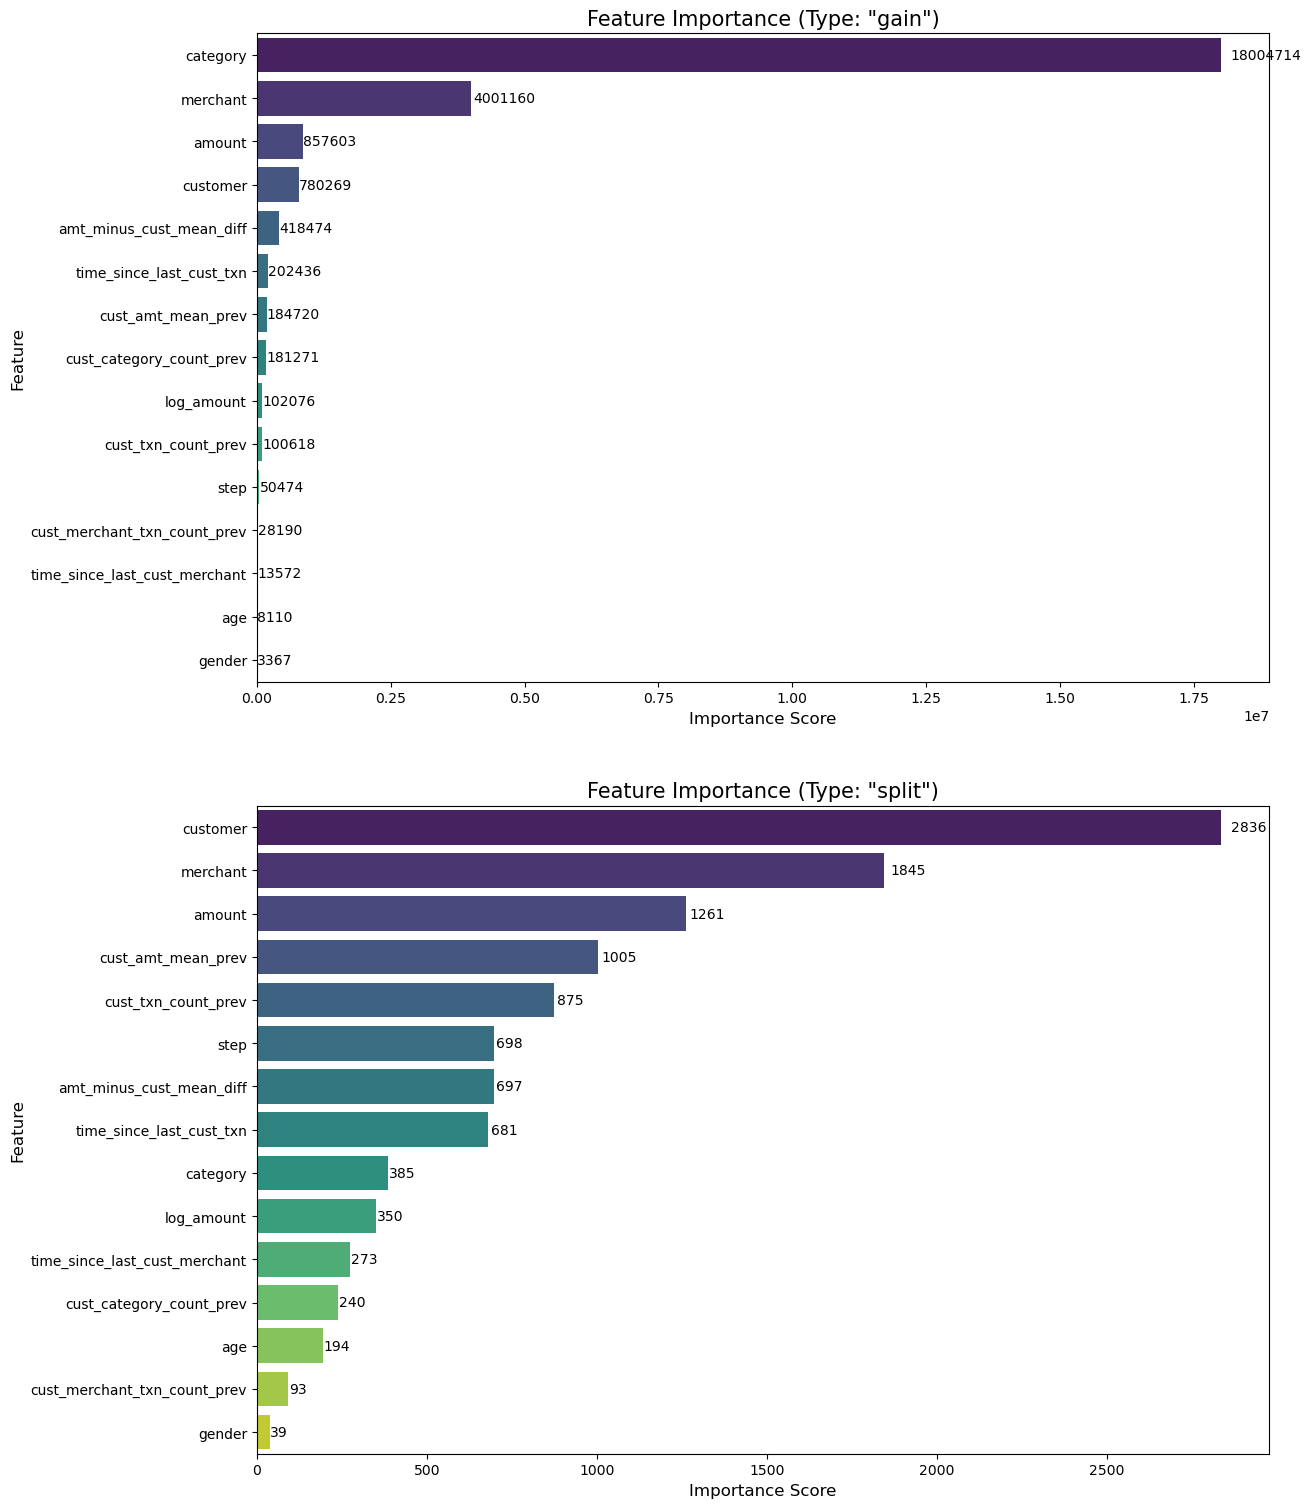

In [34]:
feature_names = [
    'step', 'age', 'gender', 'category', 'amount',
    'customer', 'merchant',
    'log_amount', 'cust_txn_count_prev', 'cust_amt_mean_prev',
    'amt_minus_cust_mean_diff', 'time_since_last_cust_txn',
    'time_since_last_cust_merchant', 'cust_merchant_txn_count_prev',
    'cust_category_count_prev'
]

# Helper function to get data and plot
def create_importance_plot(model, feature_names, importance_type, ax):
    """Creates a sorted bar plot for a given importance type on a given matplotlib axis."""
    
    # 1. Get feature importances from the model
    
    if importance_type == 'split':
        # The .feature_importances_ attribute (plural, with underscore)
        # defaults to 'split' for an LGBMClassifier.
        importances = model.feature_importances_
    elif importance_type == 'gain':
        # For 'gain', we must access the internal booster object
        # and call the .feature_importance() METHOD.
        importances = model.booster_.feature_importance(importance_type='gain')
    else:
        # General fallback for other types if needed
        importances = model.booster_.feature_importance(importance_type=importance_type)
        
    # 2. Create DataFrame
    df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False)
    
    # 3. Print the table to the console
    print(f"\n--- Top Features (by {importance_type}) ---")
    print(df.to_markdown(index=False))
    
    # 4. Plot with Seaborn
    sns.barplot(
        x='importance', 
        y='feature', 
        data=df, 
        palette='viridis', 
        ax=ax,
        hue='feature',
        legend=False
    )
    
    ax.set_title(f'Feature Importance (Type: "{importance_type}")', fontsize=15)
    ax.set_xlabel('Importance Score', fontsize=12)
    ax.set_ylabel('Feature', fontsize=12)
    
    # 5. Add data labels to the bars
    for p in ax.patches:
        width = p.get_width()
        # Only add label if importance is high enough to see
        if width > 0: 
            ax.text(width * 1.01, # x-position (slight offset from bar end)
                    p.get_y() + p.get_height() / 2, # y-position (centered)
                    f'{width:.0f}', # The label text (formatted as integer)
                    va='center',
                    fontsize=10)
                    

# --- Main Plotting ---
# Check if final_model exists
if 'final_model' not in locals() and 'final_model' not in globals():
    print("\n--- ERROR ---")
    print("The 'final_model' object was not found in memory.")
    print("Please run your loading cell first and then re-run this cell.")
else:
    # Create the dashboard figure
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 16))
    
    # Plot 1: "Gain"
    create_importance_plot(model=final_model, 
                            feature_names=feature_names, 
                            importance_type='gain', 
                            ax=axes[0])
    
    # Plot 2: "Split"
    create_importance_plot(model=final_model, 
                            feature_names=feature_names, 
                            importance_type='split', 
                            ax=axes[1])
    
    # Final adjustments
    plt.tight_layout(pad=4.0) # Add padding between plots
    
    plt.show()

### Split and Gain

* **Split**: This metric measures the number of times a specific feature is used to split the data across all the decision trees in the model. It indicates how often a feature is involved in the decision-making process. Split importance is useful for a quick overview of which features the model is using most frequently. However, it **treats all splits equally, regardless of the improvement they provide** to the model's accuracy or loss.

* **Gain**: This metric quantifies the total improvement or reduction in the objective (loss) function achieved by splits using that feature across all trees. Gain provides a more informative and accurate measure of feature importance as it **considers the quality and impact of the splits**. A feature might be used many times (high split importance) but result in only minor improvements (low gain importance), or vice versa. Gain importance is generally the recommended metric for a more meaningful assessment of how much each feature contributes to the model's overall performance.


## Classification Report and Confusion Matrix


--- Classification Report (Default 0.5 Threshold) ---
               precision    recall  f1-score   support

Non-Fraud (0)       1.00      0.99      1.00    117489
    Fraud (1)       0.57      0.96      0.72      1440

     accuracy                           0.99    118929
    macro avg       0.78      0.98      0.86    118929
 weighted avg       0.99      0.99      0.99    118929


--- Confusion Matrix (Default 0.5 Threshold) ---


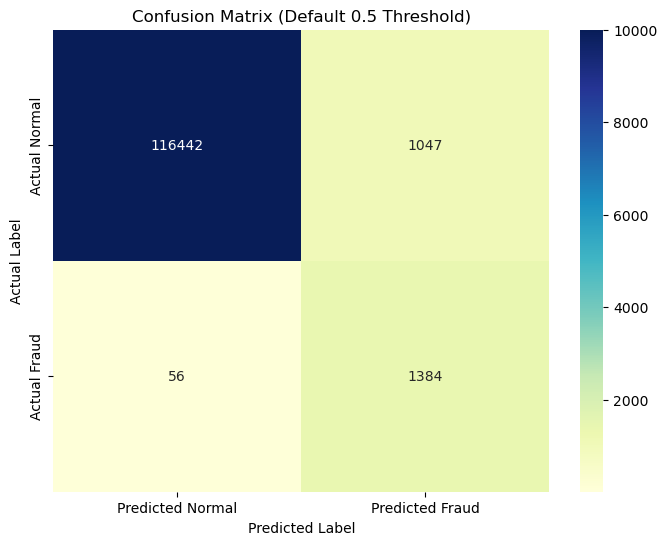

In [75]:
y_final_pred = (proba_test > 0.5).astype(int)

print("\n--- Classification Report (Default 0.5 Threshold) ---")
print(classification_report(y_test, y_final_pred, target_names=['Non-Fraud (0)', 'Fraud (1)']))

# defining the confusion matrix
print("\n--- Confusion Matrix (Default 0.5 Threshold) ---")
cm = confusion_matrix(y_test, y_final_pred)

# plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', vmin=10, vmax=10000,
            xticklabels=['Predicted Normal', 'Predicted Fraud'],
            yticklabels=['Actual Normal', 'Actual Fraud'])
plt.title('Confusion Matrix (Default 0.5 Threshold)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

## Precision-Recall Trade-Off
The model is exceptionally good at identifying non-fraudulent cases, but struggles a bit with balancing precision and recall for fraudulent cases. In fact, when it predicts fraud, it's right slightly more than half the time (57%). 
The good news is that it catches 96% of all actual fraud cases that occur.

With the following code, we can see the trade-off between precision and recall by setting different thresholds (for the previous results, a default threshold of 0.5 was used).

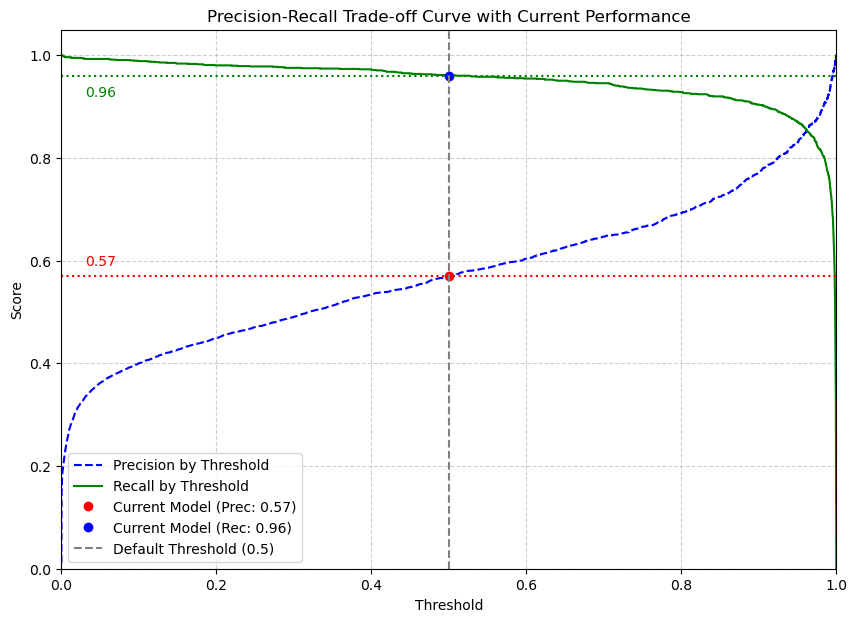

In [ ]:
current_precision = 0.57
current_recall = 0.96 
default_threshold = 0.5

precisions, recalls, thresholds = precision_recall_curve(y_test, proba_test)

# Plotting the curve helps you select the optimal threshold visually
plt.figure(figsize=(10, 7))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision by Threshold')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall by Threshold')

# --- Adding specific data points and lines ---

# 1. Plot two specific points for the current model performance at threshold 0.5
plt.plot(
    default_threshold, 
    current_precision, 
    'ro',                 
    markersize=6, 
    label=f'Current Model (Prec: {current_precision:.2f})'
)

plt.plot(
    default_threshold,
    current_recall,
    'bo',
    markersize=6,
    label=f'Current Model (Rec: {current_recall:.2f})'
)

# 2. Add horizontal and vertical lines
plt.axhline(
    y=current_precision, 
    color='r', 
    linestyle=':', 
    linewidth=1.5
)
plt.axhline(
    y=current_recall, 
    color='g', 
    linestyle=':', 
    linewidth=1.5
)
plt.axvline(
    x=default_threshold, 
    color='gray', 
    linestyle='--', 
    linewidth=1.5, 
    label='Default Threshold (0.5)'
)

# 3. Add text
plt.text(0.03, current_precision + 0.02, f'{current_precision:.2f}', color='red')
plt.text(0.03, current_recall - 0.04, f'{current_recall:.2f}', color='green')



plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend(loc='lower left')
plt.title('Precision-Recall Trade-off Curve with Current Performance')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim([0.0, 1.0]) # Ensure thresholds go from 0 to 1
plt.ylim([0.0, 1.05]) # Ensure score goes from 0 to 1
plt.show()


## Alternative Threshold
By checking the Precision-Recall Trade-off curve, we can change the threshold used by the model to flag a transaction as fraudulent. Here's a threshold of 0.85 that, by sacrificing a bit of Recall (from 0.96 to 0.92), strongly improve the precision of the model when frauds are predicted. 


--- Classification Report (0.85 Threshold) ---
               precision    recall  f1-score   support

Non-Fraud (0)       1.00      1.00      1.00    117489
    Fraud (1)       0.72      0.92      0.81      1440

     accuracy                           0.99    118929
    macro avg       0.86      0.96      0.90    118929
 weighted avg       1.00      0.99      1.00    118929


--- Confusion Matrix (0.85 Threshold) ---


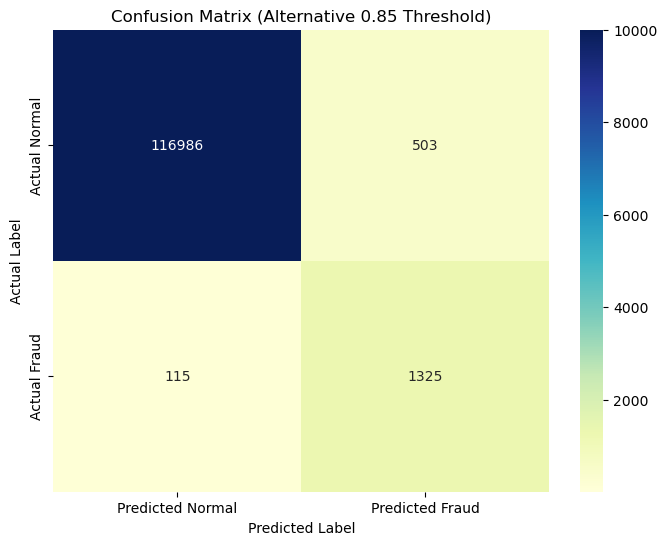

In [86]:
y_final_pred2 = (proba_test > 0.85).astype(int)

print("\n--- Classification Report (0.85 Threshold) ---")
print(classification_report(y_test, y_final_pred2, target_names=['Non-Fraud (0)', 'Fraud (1)']))

# defining the confusion matrix
print("\n--- Confusion Matrix (0.85 Threshold) ---")
cm2 = confusion_matrix(y_test, y_final_pred2)

# plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt='d', cmap='YlGnBu', vmin=10, vmax=10000,
            xticklabels=['Predicted Normal', 'Predicted Fraud'],
            yticklabels=['Actual Normal', 'Actual Fraud'])
plt.title('Confusion Matrix (Alternative 0.85 Threshold)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

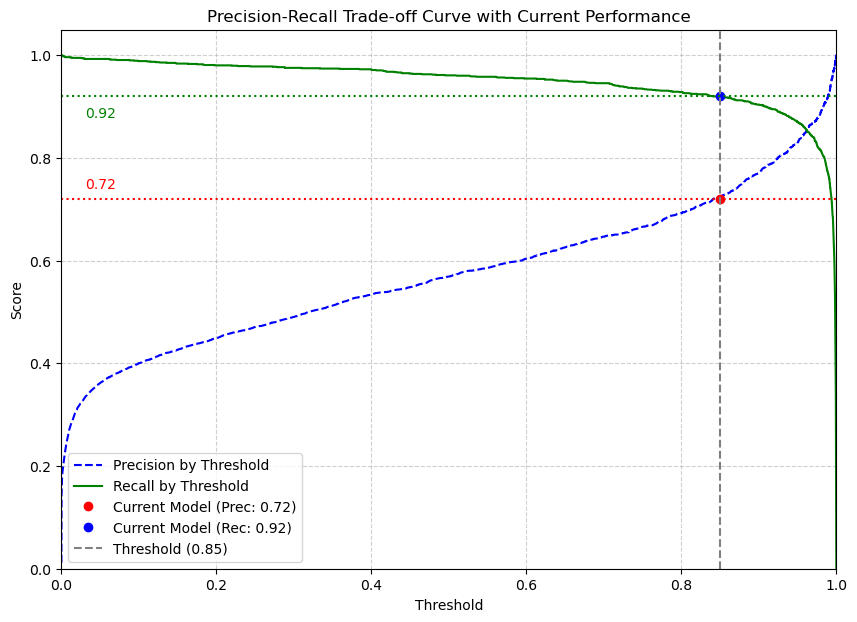

In [31]:
current_precision = 0.72
current_recall = 0.92 
nthreshold = 0.85

precisions, recalls, thresholds = precision_recall_curve(y_test, proba_test)

# Plotting the curve helps you select the optimal threshold visually
plt.figure(figsize=(10, 7))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision by Threshold')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall by Threshold')

# --- Adding specific data points and lines ---

# 1. Plot two specific points for the current model performance at threshold 0.5
plt.plot(
    nthreshold, 
    current_precision, 
    'ro',                 
    markersize=6, 
    label=f'Current Model (Prec: {current_precision:.2f})'
)

plt.plot(
    nthreshold,
    current_recall,
    'bo',
    markersize=6,
    label=f'Current Model (Rec: {current_recall:.2f})'
)

# 2. Add horizontal and vertical lines
plt.axhline(
    y=current_precision, 
    color='r', 
    linestyle=':', 
    linewidth=1.5
)
plt.axhline(
    y=current_recall, 
    color='g', 
    linestyle=':', 
    linewidth=1.5
)
plt.axvline(
    x=nthreshold, 
    color='gray', 
    linestyle='--', 
    linewidth=1.5, 
    label='Threshold (0.85)'
)

# 3. Add text
plt.text(0.03, current_precision + 0.02, f'{current_precision:.2f}', color='red')
plt.text(0.03, current_recall - 0.04, f'{current_recall:.2f}', color='green')



plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend(loc='lower left')
plt.title('Precision-Recall Trade-off Curve with Current Performance')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim([0.0, 1.0]) # Ensure thresholds go from 0 to 1
plt.ylim([0.0, 1.05]) # Ensure score goes from 0 to 1
plt.show()


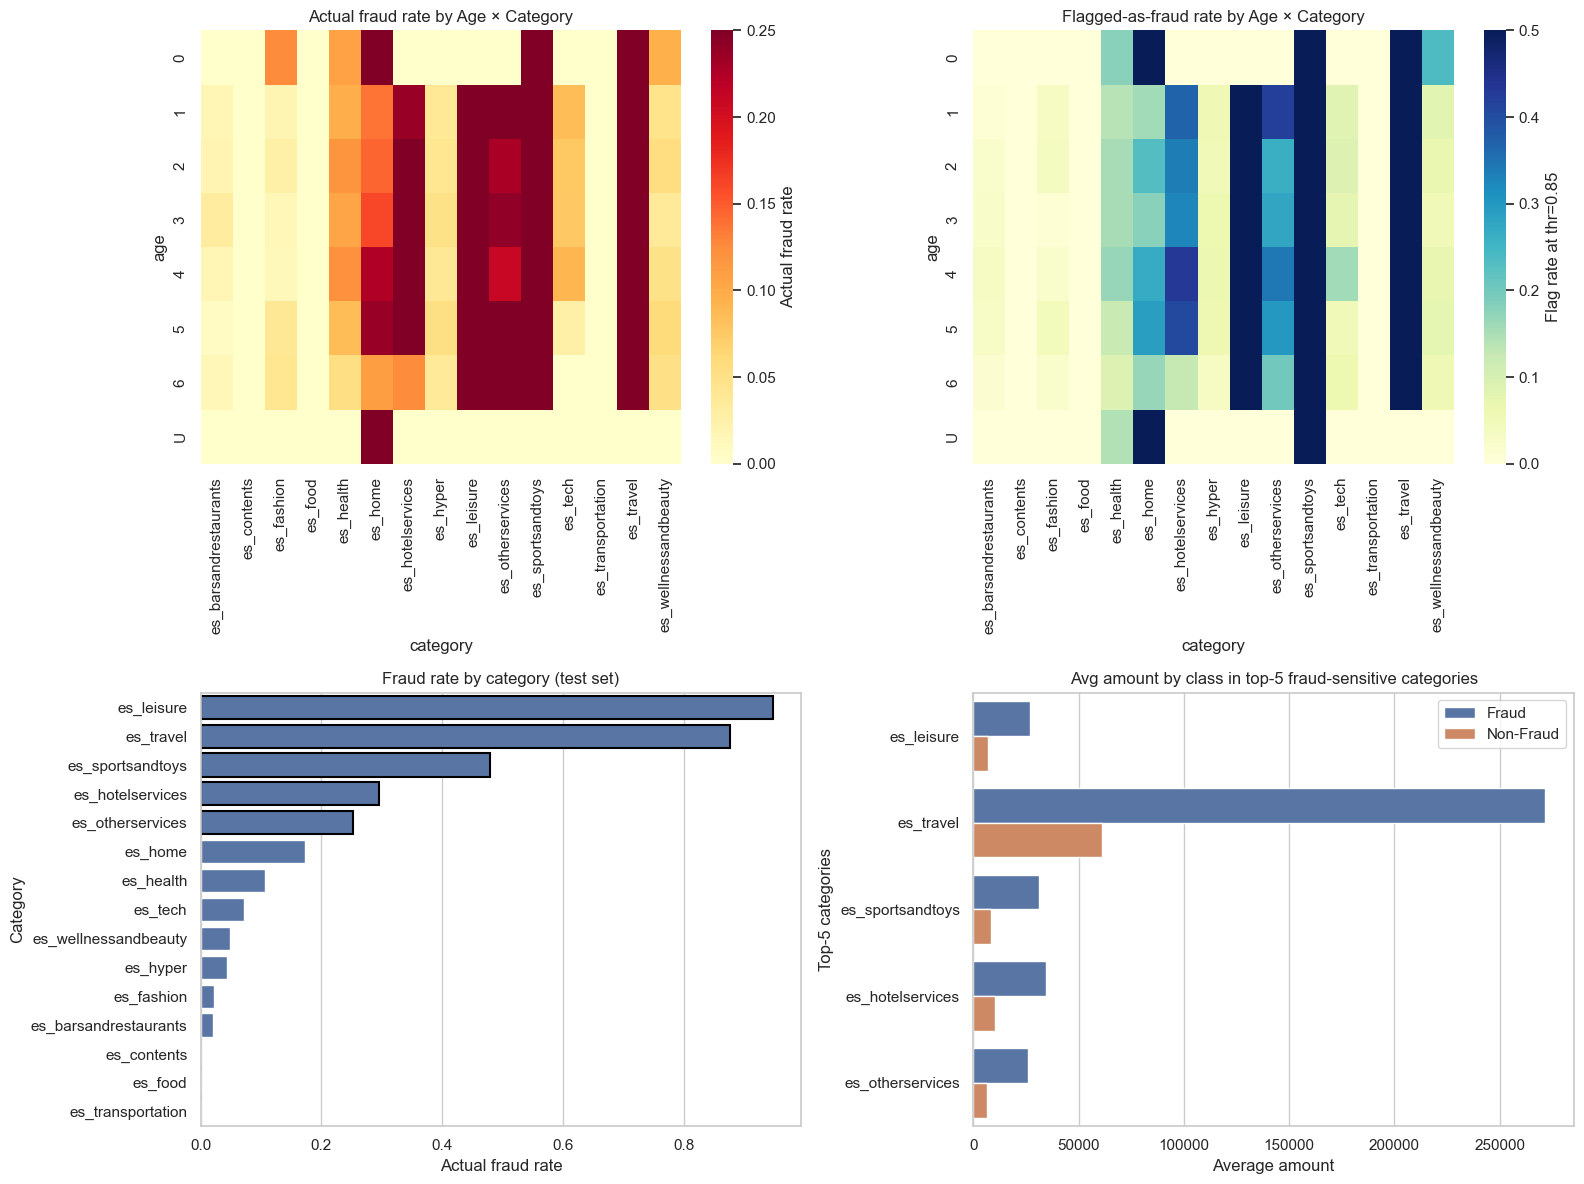


Top-5 fraud-sensitive categories (by actual fraud rate):
                  fraud_rate  count
category                           
es_leisure            0.9474     95
es_travel             0.8759    137
es_sportsandtoys      0.4786    771
es_hotelservices      0.2948    346
es_otherservices      0.2525    198


In [ ]:
# %% [markdown]
# ### Fraud patterns dashboard (actual vs flagged) + top-5 categories amounts
# - Heatmap 1: Actual fraud RATE by Age × Category
# - Heatmap 2: Flagged-as-fraud RATE (at thr) by Age × Category
# - Bar 3: Overall fraud rate by category (top-15 sorted)
# - Bar 4: Average amount for Fraud vs Non-Fraud in the top-5 fraud-sensitive categories

# 0) Set alert/flagging threshold
thr = 0.85  # change if you prefer a different operating point

# 1) Build a compact evaluation frame from your test set
df_eval = X_test.copy()
df_eval = df_eval.assign(
    label = y_test.values.astype(int),                 # actual fraud (0/1)
    flagged = (proba_test >= thr).astype(int)          # model flag (0/1)
)

# Make sure plotting keys are strings (age may be categorical)
df_eval['age'] = df_eval['age'].astype(str)
df_eval['category'] = df_eval['category'].astype(str)

# 2) Heatmaps: fraud rate by Age × Category (actual vs flagged)
actual_rate = df_eval.pivot_table(index='age', columns='category', values='label', aggfunc='mean', fill_value=0)
flagged_rate = df_eval.pivot_table(index='age', columns='category', values='flagged', aggfunc='mean', fill_value=0)

# Order rows by natural age order if present
age_order = [a for a in ['0','1','2','3','4','5','6','U'] if a in actual_rate.index]
if age_order:
    actual_rate = actual_rate.loc[age_order]
    flagged_rate = flagged_rate.loc[age_order]

# 3) Overall fraud rate by category (to pick “fraud-sensitive” categories)
cat_stats = df_eval.groupby('category', observed=True)['label'].agg(['mean','size']).rename(columns={'mean':'fraud_rate','size':'count'})
cat_sorted = cat_stats.sort_values('fraud_rate', ascending=False)
top5_cats = cat_sorted.head(5).index.tolist()

# 4) Average amount for Fraud vs Non-Fraud in the top-5 categories (actual labels)
top_df = df_eval[df_eval['category'].isin(top5_cats)].copy()
amt_tbl = (top_df
           .groupby(['category','label'], observed=True)['amount']
           .mean()
           .rename('avg_amount')
           .reset_index())
amt_pivot = (amt_tbl
             .assign(label=amt_tbl['label'].map({0:'Non-Fraud', 1:'Fraud'}))
             .pivot(index='category', columns='label', values='avg_amount')
             .reindex(top5_cats))

# 5) Plot dashboard
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(2, 2, height_ratios=[1,1])

# (A) Actual fraud rate heatmap
ax1 = fig.add_subplot(gs[0,0])
sns.heatmap(actual_rate, ax=ax1, cmap='YlOrRd', vmin=0, vmax=min(0.25, actual_rate.values.max() + 1e-9),
            cbar_kws={'label':'Actual fraud rate'})
ax1.set_title('Actual fraud rate by Age × Category')

# (B) Flagged rate heatmap (at threshold)
ax2 = fig.add_subplot(gs[0,1])
sns.heatmap(flagged_rate, ax=ax2, cmap='YlGnBu', vmin=0, vmax=min(0.50, flagged_rate.values.max() + 1e-9),
            cbar_kws={'label':f'Flag rate at thr={thr:.2f}'})
ax2.set_title('Flagged-as-fraud rate by Age × Category')

# (C) Overall fraud rate by category (sorted)
ax3 = fig.add_subplot(gs[1,0])
plot_cat = cat_sorted.reset_index()
sns.barplot(data=plot_cat, x='fraud_rate', y='category', ax=ax3)
ax3.set_xlabel('Actual fraud rate'); ax3.set_ylabel('Category')
ax3.set_title('Fraud rate by category (test set)')
# highlight top-5
for p, cat in zip(ax3.patches, plot_cat['category']):
    if cat in top5_cats:
        p.set_edgecolor('black'); p.set_linewidth(1.5)

# (D) Avg amount for Fraud vs Non-Fraud in top-5 fraud-sensitive categories
ax4 = fig.add_subplot(gs[1,1])
amt_plot = amt_pivot.reset_index().melt(id_vars='category', value_name='avg_amount', var_name='Class')
sns.barplot(data=amt_plot, x='avg_amount', y='category', hue='Class', ax=ax4)
ax4.set_xlabel('Average amount'); ax4.set_ylabel('Top-5 categories')
ax4.set_title('Avg amount by class in top-5 fraud-sensitive categories')
ax4.legend(title='')

plt.tight_layout()
plt.show()

# 6) Text summary in the notebook output
print("\nTop-5 fraud-sensitive categories (by actual fraud rate):")
print(cat_sorted.head(5).round({'fraud_rate':4}))
